In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklego.preprocessing import RepeatingBasisFunction
from sklearn.model_selection import train_test_split

%matplotlib inline

In [108]:
df = pd.read_csv('techparams_train.csv')
df.head()

,index,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,...,configurations_front-brake,configurations_safety-rating,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male,target
0,0,9,-1.0,36457,9.0,4.3,0,3,4,2006,...,1,2,13,40.0,2018.0,16,3,0,1,2360
1,2,3,-1.0,44872,8.0,-1.0,3,7,4,1982,...,4,2,13,108.0,1993.0,34,3,0,1,3060
2,4,3,-1.0,55927,16.0,4.2,0,4,5,2014,...,4,2,13,55.0,2019.0,35,3,0,1,2648
3,5,0,-1.0,41405,10.3,-1.0,0,4,4,2000,...,4,2,13,55.0,2003.0,10,3,0,1,2513
4,7,8,-1.0,22523,19.0,-1.0,0,4,8,2000,...,4,1,13,62.0,2005.0,10,3,0,1,2703


Данные: технические характеристики разных конфигураций автомобилей

Таргет: длина колесной базы конфигурации (в миллиметрах).

Задача: добиться наименьшего MSE на test.

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43245 entries, 0 to 43244
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           43245 non-null  int64  
 1   back-suspension                 43245 non-null  int64  
 2   battery-capacity                43245 non-null  float64
 3   charge-time                     43245 non-null  int64  
 4   compression                     43245 non-null  float64
 5   consumption-mixed               43245 non-null  float64
 6   cylinders-order                 43245 non-null  int64  
 7   cylinders-value                 43245 non-null  int64  
 8   engine-feeding                  43245 non-null  int64  
 9   engine-start                    43245 non-null  int64  
 10  engine-stop                     43245 non-null  int64  
 11  engine-type                     43245 non-null  int64  
 12  gear-type                       

In [110]:
df.duplicated().sum()

np.int64(0)

In [111]:
df.T.duplicated().sum()

np.int64(0)

Можем удалить столбец с индексами, поскольку они почти полностью дублируют сами индексы

In [112]:
df = df.drop(columns='index')

In [113]:
df.head()

,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,engine-stop,...,configurations_front-brake,configurations_safety-rating,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male,target
0,9,-1.0,36457,9.0,4.3,0,3,4,2006,2018,...,1,2,13,40.0,2018.0,16,3,0,1,2360
1,3,-1.0,44872,8.0,-1.0,3,7,4,1982,1993,...,4,2,13,108.0,1993.0,34,3,0,1,3060
2,3,-1.0,55927,16.0,4.2,0,4,5,2014,2018,...,4,2,13,55.0,2019.0,35,3,0,1,2648
3,0,-1.0,41405,10.3,-1.0,0,4,4,2000,2003,...,4,2,13,55.0,2003.0,10,3,0,1,2513
4,8,-1.0,22523,19.0,-1.0,0,4,8,2000,2005,...,4,1,13,62.0,2005.0,10,3,0,1,2703


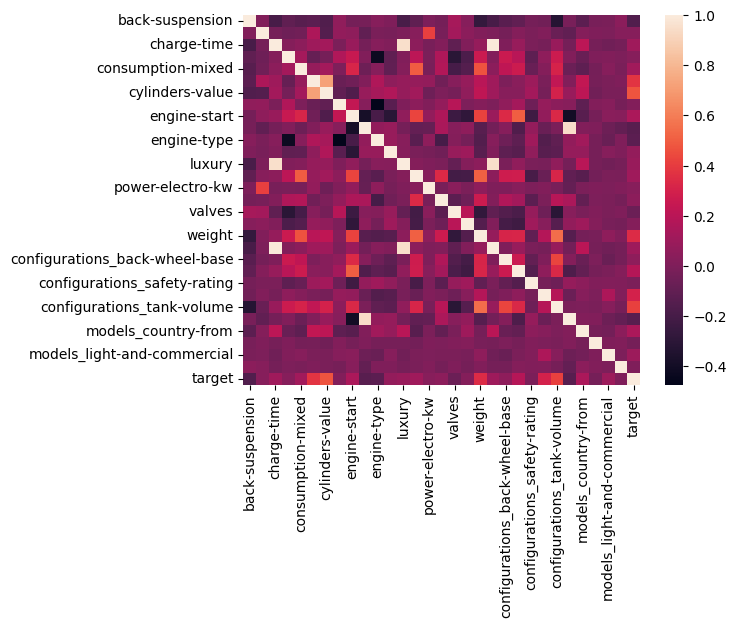

In [114]:
sns.heatmap(df.corr())
plt.show()

In [115]:
#найдем переменные с наиболее высокой корреляцией с помощью корреляционной матрицы
correlation_matrix = df.corr()

#оставим только корреляцию с target
correlation_with_target = pd.DataFrame(data=correlation_matrix['target'])
#выведем в красивом формате
correlation_with_target.sort_values(by='target', ascending=False).T

,target,cylinders-value,configurations_tank-volume,cylinders-order,weight,configurations_seats,configurations_front-brake,engine-start,models_country-from,consumption-mixed,...,valvetrain,engine-feeding,models_male,configurations_safety-rating,models_group,valves,engine-type,supergen_year-stop,engine-stop,back-suspension
target,1.0,0.472177,0.413853,0.376272,0.339835,0.298625,0.184791,0.150944,0.148848,0.118195,...,0.02112,0.012235,0.003423,-0.007558,-0.031663,-0.066402,-0.125304,-0.136986,-0.137719,-0.159912


In [116]:
X_best = df[['cylinders-value', "configurations_tank-volume", "cylinders-order", 'weight',
'configurations_seats', 'configurations_front-brake', 'engine-start', 'models_country-from',
'consumption-mixed', 'engine-type', 'supergen_year-stop', 'engine-stop', 'back-suspension']]
y = df[['target']]

train_X_b, test_X_b, train_y, test_y = train_test_split(X_best, y, test_size=0.33, random_state=42)

In [117]:
train_X_b

,cylinders-value,configurations_tank-volume,cylinders-order,weight,configurations_seats,configurations_front-brake,engine-start,models_country-from,consumption-mixed,engine-type,supergen_year-stop,engine-stop,back-suspension
22607,4,50.0,0,1290.0,13,4,1997,16,-1.0,2,2000.0,2000,3
36531,4,48.0,0,935.0,13,1,1990,23,-1.0,2,1996.0,1993,8
24048,4,56.0,0,1373.0,13,4,2009,10,6.8,2,2012.0,2012,8
34819,4,56.0,0,1430.0,13,4,2015,16,5.3,0,2017.0,2017,3
1328,5,70.0,0,1485.0,13,4,2004,28,7.5,0,2009.0,2005,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,4,68.0,0,1655.0,13,4,2017,10,4.7,0,-1.0,0,6
11284,7,82.0,3,-1.0,13,4,1987,34,-1.0,2,1996.0,1990,0
38158,4,62.0,0,1562.0,13,4,2018,26,7.6,2,-1.0,0,3
860,4,50.0,0,-1.0,13,1,1992,16,-1.0,0,1995.0,1995,10


In [118]:
test_X_b.head()

,cylinders-value,configurations_tank-volume,cylinders-order,weight,configurations_seats,configurations_front-brake,engine-start,models_country-from,consumption-mixed,engine-type,supergen_year-stop,engine-stop,back-suspension
22894,4,-1.0,0,-1.0,4,1,1984,35,-1.0,2,1988.0,1988,10
27055,6,-1.0,0,-1.0,13,1,1977,34,-1.0,2,1986.0,1982,10
40027,4,45.0,0,1163.0,13,4,2012,34,5.5,2,2014.0,2014,8
41228,3,37.0,0,760.0,13,1,1987,16,-1.0,2,1993.0,1993,3
20814,4,70.0,0,1425.0,13,4,2004,10,-1.0,2,2009.0,2008,3


# Linear Regression

In [119]:
reg_b = LinearRegression().fit(train_X_b, train_y)

In [120]:
#смотрим коэффикиент детерминации
reg_b.score(train_X_b, train_y), reg_b.score(test_X_b, test_y)
#видим,что коэффициент детерминации относительно невысокий - 
#возможно, имеет смысл рассматривать связь со всеми признаками

(0.4171766084205437, 0.42622292092455705)

In [121]:
#Рассмотрим также и MSE, минимальное значение которого нам надо получить
mean_squared_error(reg_b.predict(train_X_b), train_y), mean_squared_error(reg_b.predict(test_X_b), test_y)
#далее рассмотрим значения MSE при включении всех столбцов в х

(np.float64(31942.736557040367), np.float64(33246.103725106026))

Бинарная:<br> <code>models_light-and-commercial </code>

In [122]:
X = df.drop(['target'], axis=1)
y = df[['target']]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [123]:
train_X.head()

,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,engine-stop,...,configurations_back-wheel-base,configurations_front-brake,configurations_safety-rating,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male
22607,3,-1.0,11636,9.5,-1.0,0,4,4,1997,2000,...,1415.0,4,2,13,50.0,2000.0,16,3,0,1
36531,8,-1.0,31764,9.0,-1.0,0,4,0,1990,1993,...,1310.0,1,2,13,48.0,1996.0,23,3,0,0
24048,8,-1.0,2773,8.8,6.8,0,4,4,2009,2012,...,1558.0,4,1,13,56.0,2012.0,10,3,0,1
34819,3,-1.0,52039,14.0,5.3,0,4,5,2015,2017,...,1590.0,4,2,13,56.0,2017.0,16,3,0,0
1328,3,-1.0,20689,18.0,7.5,0,5,5,2004,2005,...,1560.0,4,2,13,70.0,2009.0,28,3,0,1


In [124]:
reg = LinearRegression().fit(train_X, train_y)

In [125]:
#смотрим коэффикиент детерминации
reg.score(train_X, train_y), reg.score(test_X, test_y)
#показатели несколько лучше, чем в прошлый раз

(0.45548738550350776, 0.4647153732232179)

In [126]:
#Рассмотрим также и MSE, минимальное значение которого нам надо получить
mean_squared_error(reg.predict(train_X), train_y), mean_squared_error(reg.predict(test_X), test_y)
#Показатель MSE также лучше (меньше), чем в прошлый раз 

(np.float64(29843.04207439402), np.float64(31015.75310911931))

# Кодирование с синусом / косинусом

In [127]:
def sin_transformer(period):
 return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
 return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [128]:
X.head()

,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,engine-stop,...,configurations_back-wheel-base,configurations_front-brake,configurations_safety-rating,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male
0,9,-1.0,36457,9.0,4.3,0,3,4,2006,2018,...,1300.0,1,2,13,40.0,2018.0,16,3,0,1
1,3,-1.0,44872,8.0,-1.0,3,7,4,1982,1993,...,1555.0,4,2,13,108.0,1993.0,34,3,0,1
2,3,-1.0,55927,16.0,4.2,0,4,5,2014,2018,...,1534.0,4,2,13,55.0,2019.0,35,3,0,1
3,0,-1.0,41405,10.3,-1.0,0,4,4,2000,2003,...,1495.0,4,2,13,55.0,2003.0,10,3,0,1
4,8,-1.0,22523,19.0,-1.0,0,4,8,2000,2005,...,1515.0,4,1,13,62.0,2005.0,10,3,0,1


In [129]:
X_2 = X.copy()
for i in range(len(X_2.columns)):
    name = X_2.columns[i]
    name_sin = X_2.columns[i] + '_sin'
    name_cos = X_2.columns[i] + '_cos'
    X_2[name_sin] = sin_transformer(X_2[name].nunique()).fit_transform(X_2)[name]
    X_2[name_cos] = sin_transformer(X_2[name].nunique()).fit_transform(X_2)[name]
X_2.head(3)

,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,engine-stop,...,supergen_year-stop_sin,supergen_year-stop_cos,models_country-from_sin,models_country-from_cos,models_group_sin,models_group_cos,models_light-and-commercial_sin,models_light-and-commercial_cos,models_male_sin,models_male_cos
0,9,-1.0,36457,9.0,4.3,0,3,4,2006,2018,...,-0.942732,-0.942732,0.342020,0.342020,-1.0,-1.0,0.0,0.0,0.013397,0.013397
1,3,-1.0,44872,8.0,-1.0,3,7,4,1982,1993,...,-0.287378,-0.287378,-0.342020,-0.342020,-1.0,-1.0,0.0,0.0,0.013397,0.013397
2,3,-1.0,55927,16.0,4.2,0,4,5,2014,2018,...,-0.919164,-0.919164,-0.173648,-0.173648,-1.0,-1.0,0.0,0.0,0.013397,0.013397


In [130]:
train_end = train_X.shape[0]

X_2_sin_cos = X_2.drop(['back-suspension', 'battery-capacity', 'charge-time', 'compression', 'consumption-mixed', 'cylinders-order', 
                         'cylinders-value', 'engine-feeding', 'engine-start', 'engine-stop', 'engine-type','gear-type', 'luxury', 
                         'max-speed', 'power-electro-kw', 'supply-system', 'valves', 'valvetrain','weight','configurations_auto-premiere',
                         'configurations_back-wheel-base', 'configurations_front-brake', 'configurations_safety-rating',
                         'configurations_seats','configurations_tank-volume', 'supergen_year-stop','models_country-from', 'models_group', 
                         'models_light-and-commercial', 'models_male'], axis=1)


In [131]:
model_2 = LinearRegression().fit(X_2_sin_cos.iloc[:train_end], y.iloc[:train_end])

In [132]:
mean_squared_error(model_2.predict(X_2_sin_cos.iloc[:train_end]), train_y)

np.float64(82330.90976361895)

MSE выше, чем по всех предыдущих случаях

## Попробуем использовать только переменные, имеющие лучшую связь с длиной колесной базы

In [133]:
X_2_best = X_best.copy()
X_2_best.head(1)

,cylinders-value,configurations_tank-volume,cylinders-order,weight,configurations_seats,configurations_front-brake,engine-start,models_country-from,consumption-mixed,engine-type,supergen_year-stop,engine-stop,back-suspension
0,3,40.0,0,820.0,13,1,2006,16,4.3,2,2018.0,2018,9


In [134]:
for i in range(len(X_2_best.columns)):
    name = X_2_best.columns[i]
    name_sin = X_2_best.columns[i] + '_sin'
    name_cos = X_2_best.columns[i] + '_cos'
    X_2_best[name_sin] = sin_transformer(X_2_best[name].nunique()).fit_transform(X_2_best)[name]
    X_2_best[name_cos] = sin_transformer(X_2_best[name].nunique()).fit_transform(X_2_best)[name]
X_2_best.head(3)

,cylinders-value,configurations_tank-volume,cylinders-order,weight,configurations_seats,configurations_front-brake,engine-start,models_country-from,consumption-mixed,engine-type,...,consumption-mixed_sin,consumption-mixed_cos,engine-type_sin,engine-type_cos,supergen_year-stop_sin,supergen_year-stop_cos,engine-stop_sin,engine-stop_cos,back-suspension_sin,back-suspension_cos
0,3,40.0,0,820.0,13,1,2006,16,4.3,2,...,0.131412,0.131412,0.587785,0.587785,-0.942732,-0.942732,-0.942732,-0.942732,-0.909632,-0.909632
1,7,108.0,3,2350.0,13,4,1982,34,-1.0,2,...,-0.030645,-0.030645,0.587785,0.587785,-0.287378,-0.287378,-0.287378,-0.287378,0.989821,0.989821
2,4,55.0,0,1350.0,13,4,2014,35,4.2,0,...,0.128373,0.128373,0.000000,0.000000,-0.919164,-0.919164,-0.942732,-0.942732,0.989821,0.989821


In [135]:
X_2_best.columns

Index(['cylinders-value', 'configurations_tank-volume', 'cylinders-order',
       'weight', 'configurations_seats', 'configurations_front-brake',
       'engine-start', 'models_country-from', 'consumption-mixed',
       'engine-type', 'supergen_year-stop', 'engine-stop', 'back-suspension',
       'cylinders-value_sin', 'cylinders-value_cos',
       'configurations_tank-volume_sin', 'configurations_tank-volume_cos',
       'cylinders-order_sin', 'cylinders-order_cos', 'weight_sin',
       'weight_cos', 'configurations_seats_sin', 'configurations_seats_cos',
       'configurations_front-brake_sin', 'configurations_front-brake_cos',
       'engine-start_sin', 'engine-start_cos', 'models_country-from_sin',
       'models_country-from_cos', 'consumption-mixed_sin',
       'consumption-mixed_cos', 'engine-type_sin', 'engine-type_cos',
       'supergen_year-stop_sin', 'supergen_year-stop_cos', 'engine-stop_sin',
       'engine-stop_cos', 'back-suspension_sin', 'back-suspension_cos'],
      dt

In [136]:
train_end = train_X_b.shape[0]

X_2_best_sin_cos = X_2_best.drop(['cylinders-value', 'configurations_tank-volume', 'cylinders-order', 'weight', 'configurations_seats', 
                        'configurations_front-brake', 'engine-start', 'models_country-from', 'consumption-mixed', 'engine-type', 
                        'supergen_year-stop', 'engine-stop', 'back-suspension'], axis=1)
X_2_best_sin_cos.head(2)

,cylinders-value_sin,cylinders-value_cos,configurations_tank-volume_sin,configurations_tank-volume_cos,cylinders-order_sin,cylinders-order_cos,weight_sin,weight_cos,configurations_seats_sin,configurations_seats_cos,...,consumption-mixed_sin,consumption-mixed_cos,engine-type_sin,engine-type_cos,supergen_year-stop_sin,supergen_year-stop_cos,engine-stop_sin,engine-stop_cos,back-suspension_sin,back-suspension_cos
0,0.989821,0.989821,0.755750,0.755750,0.000000,0.000000,-0.058506,-0.058506,0.673696,0.673696,...,0.131412,0.131412,0.587785,0.587785,-0.942732,-0.942732,-0.942732,-0.942732,-0.909632,-0.909632
1,-0.755750,-0.755750,-0.113991,-0.113991,0.433884,0.433884,0.250957,0.250957,0.673696,0.673696,...,-0.030645,-0.030645,0.587785,0.587785,-0.287378,-0.287378,-0.287378,-0.287378,0.989821,0.989821


In [137]:
model_2_best = LinearRegression().fit(X_2_best_sin_cos.iloc[:train_end], y.iloc[:train_end])

In [138]:
mean_squared_error(model_2_best.predict(X_2_best_sin_cos.iloc[:train_end]), train_y)

np.float64(81556.33968831366)

MSE выше, чем по всех предыдущих случаях, кроме случая кодирования, но по всем переменным

# Радиальные базисные функции

RepeatingBasisFunction [применяется только к циклическим данным](https://koaning.github.io/scikit-lego/api/preprocessing/#sklego.preprocessing.repeatingbasis.RepeatingBasisFunction), но в нашем случае данные не являются циклическими. В связи с этим, преобразование не будет корректным

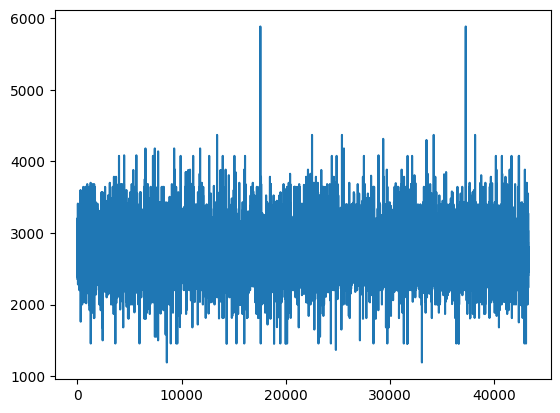

In [139]:
y['target'].plot()
plt.show()

# Приведем данные к единой шкале

In [140]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## MinMaxScaler

In [141]:
X_3 = X.copy()

scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X_3)

In [142]:
train_X_mm, test_X_mm, train_y, test_y = train_test_split(X_minmax, y, test_size=0.33, random_state=42)

In [143]:
reg_mm = LinearRegression().fit(train_X_mm, train_y)

In [144]:
mean_squared_error(reg_mm.predict(train_X_mm), train_y), mean_squared_error(reg_mm.predict(test_X_mm), test_y)

(np.float64(29843.04207439402), np.float64(31015.753109119247))

Получили, на данный момент, наименьшую MSE

## StandartScaler

In [145]:
X_4 = X.copy()

scaler = MinMaxScaler()
X_ss = scaler.fit_transform(X_4)

In [146]:
train_X_ss, test_X_ss, train_y, test_y = train_test_split(X_ss, y, test_size=0.33, random_state=42)

In [147]:
reg_ss = LinearRegression().fit(train_X_ss, train_y)

In [148]:
mean_squared_error(reg_ss.predict(train_X_ss), train_y), mean_squared_error(reg_ss.predict(test_X_ss), test_y)

(np.float64(29843.04207439402), np.float64(31015.753109119247))

## Логарифмирование

In [229]:
X_5 = X.copy()
#X_5[X_5 < 0] = np.nan
transformed_X_5 = np.log(X_5)
train_X_log, test_X_log, train_y, test_y = train_test_split(transformed_X_5, y, test_size=0.33, random_state=42)

C:\Users\96234\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\96234\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Необходимо преобразовать отрицательные (и нулевые) значения, чтобы в дальнейшем не получить ошибку

In [230]:
neg_values = [
    (X_5[X_5[name] < 0][name].unique(), name) 
    for name in X_5.columns 
    if len(X_5[X_5[name] < 0][name].unique()) > 0
]

neg_values_cols = []

for i in range(len(neg_values)):
    neg_values_cols.append(neg_values[i][1])
neg_values_cols

['battery-capacity',
 'compression',
 'consumption-mixed',
 'max-speed',
 'power-electro-kw',
 'weight',
 'configurations_back-wheel-base',
 'configurations_tank-volume',
 'supergen_year-stop']

In [231]:
for i in range(len(neg_values_cols)):
    name = neg_values_cols[i]
    print(X_5[name].unique(), name)

[ -1.    13.2   21.     1.56  41.    10.7    1.3   23.     6.5   90.
  18.4  100.    14.1    9.2  130.    24.    75.    13.5    1.4   17.6
  12.    21.3   31.3   58.    78.    60.    22.    18.8   40.     4.4
  30.    45.     8.7  120.    62.    50.    10.4    1.1   27.2  200.
  33.     6.8   93.4    1.31  64.    32.6    9.27  11.6    7.6    5.5
  14.4   16.    79.2   41.4   31.2   28.     1.5   13.    77.    17.1
   7.9   42.2   47.17  95.    37.    16.5   25.5   17.    11.2   10.8
  10.5   70.    39.2    7.7   71.  ] battery-capacity
[ 9.    8.   16.   10.3  19.    9.6  16.5  -1.   21.    8.5   9.3   9.8
 18.   10.    9.9  11.   17.    9.5  10.4   8.8  10.2  10.5  10.8   9.2
 22.    9.7  17.9  10.7  10.1  18.3  11.2   8.2   8.75 11.3  23.   10.25
  7.3  11.1  18.4  18.1   8.3   8.6  10.6  21.9   6.   16.2  15.6  19.2
  9.1  22.5   8.9  11.8   9.4  19.5  19.4  15.5  18.2  10.55 11.65 17.6
  7.   22.2   7.7  14.8   8.4  13.   17.5  14.    9.75  6.5   7.8  16.8
 18.8  15.4   7.4   7.5  

Для преобразования воспользуемся функцией <code>np.log1p</code>, вместо <code>np.log</code>, предварительно заменив отрицательные значения на средние

In [232]:
from sklearn.impute import SimpleImputer

X_5[X_5 < 0] = np.nan

imputer = SimpleImputer(strategy="median")
X_5 = imputer.fit_transform(X_5)

transformed_X_5 = np.log1p(X_5)
train_X_log, test_X_log, train_y, test_y = train_test_split(transformed_X_5, y, test_size=0.33, random_state=42)

In [233]:
reg_log = LinearRegression().fit(train_X_log, train_y)

In [234]:
mean_squared_error(reg_log.predict(train_X_log), train_y), mean_squared_error(reg_log.predict(test_X_log), test_y)

(np.float64(23458.35575125369), np.float64(24360.368827990154))

Получили наименьшее значение MSE из всех рассмотренных моделей

## Преобразование Бокса-Кокса

In [221]:
from scipy. stats import boxcox

In [246]:
X_6 = X.copy()
X_6.columns

Index(['back-suspension', 'battery-capacity', 'charge-time', 'compression',
       'consumption-mixed', 'cylinders-order', 'cylinders-value',
       'engine-feeding', 'engine-start', 'engine-stop', 'engine-type',
       'gear-type', 'luxury', 'max-speed', 'power-electro-kw', 'supply-system',
       'valves', 'valvetrain', 'weight', 'configurations_auto-premiere',
       'configurations_back-wheel-base', 'configurations_front-brake',
       'configurations_safety-rating', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop',
       'models_country-from', 'models_group', 'models_light-and-commercial',
       'models_male'],
      dtype='object')

Для преобразования Бокса-Кокса нужно, чтобы значения столбцов были положительными

In [254]:
X_6[X_6 < 0] = np.nan
imputer = SimpleImputer(strategy="median")
X_6_pos = imputer.fit_transform(X_6)
X_6_pos

array([[9.0000e+00, 2.2000e+01, 3.6457e+04, ..., 3.0000e+00, 0.0000e+00,
        1.0000e+00],
       [3.0000e+00, 2.2000e+01, 4.4872e+04, ..., 3.0000e+00, 0.0000e+00,
        1.0000e+00],
       [3.0000e+00, 2.2000e+01, 5.5927e+04, ..., 3.0000e+00, 0.0000e+00,
        1.0000e+00],
       ...,
       [3.0000e+00, 2.2000e+01, 8.9580e+03, ..., 3.0000e+00, 0.0000e+00,
        1.0000e+00],
       [3.0000e+00, 2.2000e+01, 2.0293e+04, ..., 3.0000e+00, 0.0000e+00,
        1.0000e+00],
       [1.0000e+01, 2.2000e+01, 5.2459e+04, ..., 3.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [255]:
X_6_pos = pd.DataFrame(X_6_pos, columns=['back-suspension', 'battery-capacity', 'charge-time', 'compression',
       'consumption-mixed', 'cylinders-order', 'cylinders-value',
       'engine-feeding', 'engine-start', 'engine-stop', 'engine-type',
       'gear-type', 'luxury', 'max-speed', 'power-electro-kw', 'supply-system',
       'valves', 'valvetrain', 'weight', 'configurations_auto-premiere',
       'configurations_back-wheel-base', 'configurations_front-brake',
       'configurations_safety-rating', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop',
       'models_country-from', 'models_group', 'models_light-and-commercial',
       'models_male'])

C:\Users\96234\AppData\Local\Temp\ipykernel_3428\2858693548.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transformed_data, hist=False , kde=True)


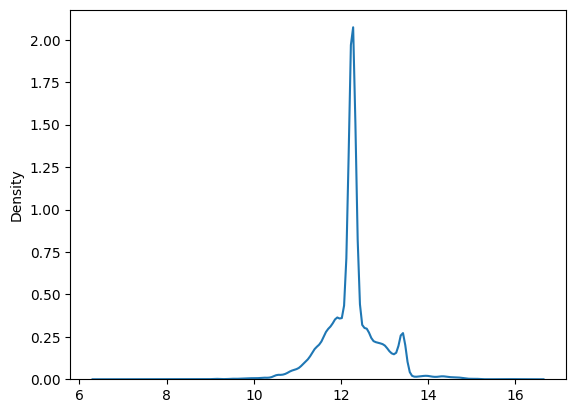

In [241]:
transformed_data, best_lambda = boxcox(X_6_pos['max-speed'])

sns.distplot(transformed_data, hist=False , kde=True)
plt.show()

In [265]:
def boxcox_trans(df):
    df_trans = df.copy()
    lambdas = {} 

    for i in df.columns:  # Применяем только к числовым данным
        if (df[i] <= 0).any():
            med_value = df[i][df[i] > 0].median() 
            df_trans[i] = df[i].apply(lambda x: med_value if x <= 0 else x) 

        if df_trans[i].nunique() < 2:
            lambdas[i] = None
            continue
            
        df_trans[i], lambda_ = boxcox(df_trans[i])
        lambdas[i] = lambda_ 

    return df_trans, lambdas

In [266]:
X_6_trans, lambdas = boxcox_trans(X_6_pos)

In [267]:
train_X_6, test_X_6, train_y, test_y = train_test_split(X_6_trans, y, test_size=0.33, random_state=42)

In [268]:
reg_bc = LinearRegression().fit(train_X_6, train_y)

In [269]:
mean_squared_error(reg_bc.predict(train_X_6), train_y), mean_squared_error(reg_bc.predict(test_X_6), test_y)

(np.float64(53471.37665674923), np.float64(56639.628018793446))

Получили наибольшее значение MSE

In [270]:
X_b_bc = X_best.copy()
X_b_bc.head()

,cylinders-value,configurations_tank-volume,cylinders-order,weight,configurations_seats,configurations_front-brake,engine-start,models_country-from,consumption-mixed,engine-type,supergen_year-stop,engine-stop,back-suspension
0,3,40.0,0,820.0,13,1,2006,16,4.3,2,2018.0,2018,9
1,7,108.0,3,2350.0,13,4,1982,34,-1.0,2,1993.0,1993,3
2,4,55.0,0,1350.0,13,4,2014,35,4.2,0,2019.0,2018,3
3,4,55.0,0,1090.0,13,4,2000,10,-1.0,2,2003.0,2003,0
4,4,62.0,0,1410.0,13,4,2000,10,-1.0,0,2005.0,2005,8


In [271]:
X_b_bc_trans, lambdas = boxcox_trans(X_b_bc)

In [275]:
train_X_b_bc, test_X_b_bc, train_y, test_y = train_test_split(X_b_bc_trans, y, test_size=0.33, random_state=42)

In [276]:
reg_b_bc = LinearRegression().fit(train_X_b_bc, train_y)

In [277]:
mean_squared_error(reg_b_bc.predict(train_X_b_bc), train_y), mean_squared_error(reg_b_bc.predict(test_X_b_bc), test_y)

(np.float64(53487.514595205095), np.float64(56654.85460290138))

# Вывод: 

### наименьший MSE (24360.3688) получили после логарифмирования. Дополнительно можно провести логарифмирование только тех столбцов, которые имеют наилучшую связь с результирующей переменной (target)

In [278]:
X_b_log = X_best.copy()
X_b_log.head(1)

,cylinders-value,configurations_tank-volume,cylinders-order,weight,configurations_seats,configurations_front-brake,engine-start,models_country-from,consumption-mixed,engine-type,supergen_year-stop,engine-stop,back-suspension
0,3,40.0,0,820.0,13,1,2006,16,4.3,2,2018.0,2018,9


In [279]:
X_b_log[X_b_log < 0] = np.nan

imputer = SimpleImputer(strategy="median")
X_b_log = imputer.fit_transform(X_b_log)

transformed_X_b_log = np.log1p(X_b_log)
train_X_b_log, test_X_b_log, train_y, test_y = train_test_split(transformed_X_b_log, y, test_size=0.33, random_state=42)

In [280]:
reg_b_log = LinearRegression().fit(train_X_b_log, train_y)

In [281]:
mean_squared_error(reg_b_log.predict(train_X_b_log), train_y), mean_squared_error(reg_b_log.predict(test_X_b_log), test_y)

(np.float64(25510.25499941767), np.float64(26449.107761506348))

MSE в данном случае выше, чем при использовании всех объясняющих переменных в модели